## How much tracer is there on the shelf?

This notebook explores the effects of changing the vertical diffusivity (constant, 3D), changing the isopycnal diffusivity in GMREDI and having a canyon vs a flat shelf on the total amount of tracer (mass) on the shelf at a certain time and place.

In [1]:
#import gsw as sw # Gibbs seawater package

from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

from MITgcmutils import rdmds

from netCDF4 import Dataset

import numpy as np

import os 

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

/home/kramosmu/anaconda/lib/python2.7/site-packages/mpl_toolkits/__init__.py:2: UserWarning: Module MITgcmutils was already imported from MITgcmutils/__init__.pyc, but /home/kramosmu/anaconda/lib/python2.7/site-packages/MITgcmutils-0.1.0-py2.7.egg is being added to sys.path
  __import__('pkg_resources').declare_namespace(__name__)


In [2]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 


In [3]:
sns.set()
sns.set_style('darkgrid')
sns.set_context('talk')

In [4]:
#Grid to use for all calculations 
NoCGrid = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run06/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
NoCGridOut = Dataset(NoCGrid)

#Varying-K_iso runs CNTDIFF:
CNTrun02 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run02/stateGlob.nc'
StateOut02 = Dataset(CNTrun02)
CNTrun02Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run02/ptracersGlob.nc'
CNTrun03Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/ptracersGlob.nc'
CNTrun04Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run04/ptracersGlob.nc'
CNTrun07Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/ptracersGlob.nc'

#Varying-K_v 3D runs
DIFF3Drun04Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run04/ptracersGlob.nc'
DIFF3Drun05Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run05/ptracersGlob.nc'
DIFF3Drun06Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run06/ptracersGlob.nc'
DIFF3Drun07Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run07/ptracersGlob.nc'

#No GMREDI runs
NORrun02Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run02/ptracersGlob.nc'
NORrun03Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run03/ptracersGlob.nc'
NORrun04Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run04/ptracersGlob.nc' # No canyon case
NORrun05Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run05/ptracersGlob.nc' # Closed Bdies
NORrun06Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run06/ptracersGlob.nc' # Closed Bdies, no canyon



In [5]:
# General input

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

rc = NoCGridOut.variables['RC']
xc = rout.getField(NoCGrid, 'XC') # x coords tracer cells
yc = rout.getField(NoCGrid, 'YC') # y coords tracer cells

drF = NoCGridOut.variables['drF'] # vertical distance between faces
dxG = rout.getField(NoCGrid,'dxG')

Mask = rout.getMask(NoCGrid,'HFacC') 
hFacC = rout.getField(NoCGrid,'HFacC') 
rA = rout.getField(NoCGrid,'rA') 
drF= NoCGridOut.variables['drF']


In [6]:
# Load tracers variable K_iso
CNT02Tr1 = rout.getField(CNTrun02Tr,'Tr1') # Tracer 1 CNT run02 , Kz = E-5
CNT02Tr3 = rout.getField(CNTrun02Tr,'Tr3') # Tracer 3 CNT run02 , Kz = E-3
CNT03Tr1 = rout.getField(CNTrun03Tr,'Tr1') # Tracer 1 CNT run03 , Kz = E-5
CNT03Tr2 = rout.getField(CNTrun03Tr,'Tr2') # Tracer 1 CNT run03 , Kz = E-5
CNT03Tr3 = rout.getField(CNTrun03Tr,'Tr3') # Tracer 3 CNT run03 , Kz = E-3
CNT04Tr1 = rout.getField(CNTrun04Tr,'Tr1') # Tracer 1 CNT run04 , Kz = E-5
CNT04Tr3 = rout.getField(CNTrun04Tr,'Tr3') # Tracer 3 CNT run04 , Kz = E-3
CNT07Tr1 = rout.getField(CNTrun07Tr,'Tr1') # Tracer 1 CNT run04 , Kz = E-5
CNT07Tr3 = rout.getField(CNTrun07Tr,'Tr3') # Tracer 3 CNT run04 , Kz = E-3


In [7]:
# Load tracers variable K_v
DIFF3D04Tr1 = rout.getField(DIFF3Drun04Tr,'Tr1') # Tracer 1 3D run01 , Kz = E-7 out, E-3 in
DIFF3D05Tr1 = rout.getField(DIFF3Drun05Tr,'Tr1') # Tracer 1 3D run02 , Kz = E-7 out, E-4 in
DIFF3D06Tr1 = rout.getField(DIFF3Drun06Tr,'Tr1') # Tracer 1 3D run06 , Kz = E-5 out, E-4 in
DIFF3D07Tr1 = rout.getField(DIFF3Drun07Tr,'Tr1') # Tracer 1 3D run03 , Kz = E-5 out, E-4 in


In [8]:
# Load tracers of no REDI run
NOR02Tr1 = rout.getField(NORrun02Tr,'Tr1') # Tracer 1 NoREDI run02 , Kz = E-5
NOR02Tr3 = rout.getField(NORrun02Tr,'Tr3') # Tracer 3 NoREDI run02 , Kz = E-3 
#NOR03Tr1 = rout.getField(NORrun03Tr,'Tr1') # Tracer 1 NoREDI run03 , Kz = E-5
#NOR03Tr3 = rout.getField(NORrun03Tr,'Tr3') # Tracer 3 NoREDI run03 , Kz = E-3 
NOR04Tr1 = rout.getField(NORrun04Tr,'Tr1') # Tracer 1 NoC NoR run04 No Redi , Kz = E-5
NOR04Tr3 = rout.getField(NORrun04Tr,'Tr3') # Tracer 3 NoC NoR run04 No redi , Kz = E-3 
NOR05Tr1 = rout.getField(NORrun05Tr,'Tr1') # Tracer 1 NoREDI run05 Closed Bdies
NOR05Tr3 = rout.getField(NORrun05Tr,'Tr3') # Tracer 3 NoREDI run05 Closed Bdies
NOR06Tr1 = rout.getField(NORrun06Tr,'Tr1') # Tracer 1 NoREDI run06 Closed Bdies, no canyon
NOR06Tr3 = rout.getField(NORrun06Tr,'Tr3') # Tracer 3 NoREDI run06 Closed Bdies, no canyon


### How much water with concentration higher than a limit is there on the shelf at each time? How much tracer mass?

In [9]:
def HowMuchWaterX(Tr,MaskC,nzlim,rA,hFacC,drF,tt,yin,zfin):
    '''
    INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    tt    : Time slice to calculate. Int 0<=tt<19
    yin   : across-shore index of shelf break
    zfin  : shelf break index + 1 
    OUTPUT----------------------------------------------------------------------------------------------------------------
    WaterX =  Float variable with the volume of water over the shelf [tt,:30,227:,:]
    TrX = Float variable with the mass of tracer (umol) at each x-position over the shelf [tt,:30,227:,:]. 
          Total mass of tracer at xx on the shelf.
                                                
    -----------------------------------------------------------------------------------------------------------------------
    '''
    TrMask0=np.ma.array(Tr[0,:,:,:],mask=MaskC[:,:,:])
        
    trlim = TrMask0[nzlim,50,180]
    
    hFacCSwap = np.swapaxes(hFacC, 0, 2)
    
    #print('tracer limit is: ',trlim)
    
    TrMask=np.ma.array(Tr[tt,:,:,:],mask=MaskC[:,:,:])
    
    WaterX = 0
    
    for ii,trac in np.ndenumerate(TrMask[:zfin,yin:,:]) :
        if trac >= trlim:
             WaterX = WaterX + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]
                
                
    VolX = (np.swapaxes(hFacCSwap[:,yin:,:zfin]*drF[:zfin],0,2))*rA[yin:,:]
          
    TrX = np.sum(VolX*TrMask[:zfin,yin:,:]*1000.0) #[1 umol/l=1000 umol/m^3]
    
                 
    return (WaterX, TrX)

### Calculate volume on shelf of high tracer concentration water and tracer mass. 

In [10]:
WatCNT02Tr1 = np.empty(nt)
WatCNT02Tr3 = np.empty(nt)

WatCNT03Tr1 = np.empty(nt)
WatCNT03Tr2 = np.empty(nt)
WatCNT03Tr3 = np.empty(nt)

WatCNT04Tr1 = np.empty(nt)
WatCNT04Tr3 = np.empty(nt)

WatCNT07Tr1 = np.empty(nt)
WatCNT07Tr3 = np.empty(nt)

TrMassCNT02Tr1 = np.empty(nt)
TrMassCNT02Tr3 = np.empty(nt)

TrMassCNT03Tr1 = np.empty(nt)
TrMassCNT03Tr2 = np.empty(nt)
TrMassCNT03Tr3 = np.empty(nt)

TrMassCNT04Tr1 = np.empty(nt)
TrMassCNT04Tr3 = np.empty(nt)

TrMassCNT07Tr1 = np.empty(nt)
TrMassCNT07Tr3 = np.empty(nt)


for time in range(0,nt,1):
    
    (WaterX1, TrX1) = HowMuchWaterX(CNT02Tr1,Mask,30,rA,hFacC,drF,time,227,30) 
    (WaterX2, TrX2) = HowMuchWaterX(CNT02Tr3,Mask,30,rA,hFacC,drF,time,227,30) 
    (WaterX3, TrX3) = HowMuchWaterX(CNT03Tr1,Mask,30,rA,hFacC,drF,time,227,30) 
    (WaterX4, TrX4) = HowMuchWaterX(CNT03Tr2,Mask,30,rA,hFacC,drF,time,227,30) 
    (WaterX5, TrX5) = HowMuchWaterX(CNT03Tr3,Mask,30,rA,hFacC,drF,time,227,30) 
    (WaterX6, TrX6) = HowMuchWaterX(CNT04Tr1,Mask,30,rA,hFacC,drF,time,227,30) 
    (WaterX7, TrX7) = HowMuchWaterX(CNT04Tr3,Mask,30,rA,hFacC,drF,time,227,30) 
    (WaterX8, TrX8) = HowMuchWaterX(CNT07Tr1,Mask,30,rA,hFacC,drF,time,227,30) 
    (WaterX9, TrX9) = HowMuchWaterX(CNT07Tr3,Mask,30,rA,hFacC,drF,time,227,30) 
        
    
    WatCNT02Tr1[time] = WaterX1
    WatCNT02Tr3[time] = WaterX2
    WatCNT03Tr1[time] = WaterX3
    WatCNT03Tr2[time] = WaterX4
    WatCNT03Tr3[time] = WaterX5
    WatCNT04Tr1[time] = WaterX6
    WatCNT04Tr3[time] = WaterX7
    WatCNT07Tr1[time] = WaterX8
    WatCNT07Tr3[time] = WaterX9

    TrMassCNT02Tr1[time] = TrX1
    TrMassCNT02Tr3[time] = TrX2
    TrMassCNT03Tr1[time] = TrX3
    TrMassCNT03Tr2[time] = TrX4
    TrMassCNT03Tr3[time] = TrX5
    TrMassCNT04Tr1[time] = TrX6
    TrMassCNT04Tr3[time] = TrX7
    TrMassCNT07Tr1[time] = TrX8
    TrMassCNT07Tr3[time] = TrX9


In [11]:
WatNOR02Tr1 = np.empty(nt)
WatNOR02Tr3 = np.empty(nt)
WatNOR04Tr1 = np.empty(nt)
WatNOR04Tr3 = np.empty(nt)
WatNOR05Tr1 = np.empty(nt)
WatNOR05Tr3 = np.empty(nt)
WatNOR06Tr1 = np.empty(nt)
WatNOR06Tr3 = np.empty(nt)

TrMassNOR02Tr1 = np.empty(nt)
TrMassNOR02Tr3 = np.empty(nt)
TrMassNOR04Tr1 = np.empty(nt)
TrMassNOR04Tr3 = np.empty(nt)
TrMassNOR05Tr1 = np.empty(nt)
TrMassNOR05Tr3 = np.empty(nt)
TrMassNOR06Tr1 = np.empty(nt)
TrMassNOR06Tr3 = np.empty(nt)


for time in range(0,nt,1):
    
    (WaterX1, TrX1) = HowMuchWaterX(NOR02Tr1,Mask,30,rA,hFacC,drF,time,227,30) 
    (WaterX2, TrX2) = HowMuchWaterX(NOR02Tr3,Mask,30,rA,hFacC,drF,time,227,30) 
    (WaterX3, TrX3) = HowMuchWaterX(NOR04Tr1,Mask,30,rA,hFacC,drF,time,227,30) 
    (WaterX4, TrX4) = HowMuchWaterX(NOR04Tr3,Mask,30,rA,hFacC,drF,time,227,30) 
    (WaterX5, TrX5) = HowMuchWaterX(NOR05Tr1,Mask,30,rA,hFacC,drF,time,227,30) 
    (WaterX6, TrX6) = HowMuchWaterX(NOR05Tr3,Mask,30,rA,hFacC,drF,time,227,30) 
    (WaterX7, TrX7) = HowMuchWaterX(NOR06Tr1,Mask,30,rA,hFacC,drF,time,227,30) 
    (WaterX8, TrX8) = HowMuchWaterX(NOR06Tr3,Mask,30,rA,hFacC,drF,time,227,30) 
       
    WatNOR02Tr1[time] = WaterX1
    WatNOR02Tr3[time] = WaterX2
    WatNOR04Tr1[time] = WaterX3
    WatNOR04Tr3[time] = WaterX4
    WatNOR05Tr1[time] = WaterX5
    WatNOR05Tr3[time] = WaterX6
    WatNOR06Tr1[time] = WaterX7
    WatNOR06Tr3[time] = WaterX8
    
    TrMassNOR02Tr1[time] = TrX1
    TrMassNOR02Tr3[time] = TrX2
    TrMassNOR04Tr1[time] = TrX3
    TrMassNOR04Tr3[time] = TrX4
    TrMassNOR05Tr1[time] = TrX5
    TrMassNOR05Tr3[time] = TrX6
    TrMassNOR06Tr1[time] = TrX7
    TrMassNOR06Tr3[time] = TrX8
    
    

In [13]:
Wat3D04Tr1 = np.empty(nt)
Wat3D05Tr1 = np.empty(16)
Wat3D06Tr1 = np.empty(nt)
Wat3D07Tr1 = np.empty(nt)

TrMass3D04Tr1 = np.empty(nt)
TrMass3D05Tr1 = np.empty(16)
TrMass3D06Tr1 = np.empty(nt)
TrMass3D07Tr1 = np.empty(nt)


for time in range(0,nt,1):
    
    (WaterX1, TrX1) = HowMuchWaterX(DIFF3D04Tr1,Mask,30,rA,hFacC,drF,time,227,30) 
    (WaterX4, TrX4) = HowMuchWaterX(DIFF3D06Tr1,Mask,30,rA,hFacC,drF,time,227,30) 
    (WaterX5, TrX5) = HowMuchWaterX(DIFF3D07Tr1,Mask,30,rA,hFacC,drF,time,227,30) 
       
    Wat3D04Tr1[time] = WaterX1
    Wat3D06Tr1[time] = WaterX4
    Wat3D07Tr1[time] = WaterX5
    
    TrMass3D04Tr1[time] = TrX1
    TrMass3D06Tr1[time] = TrX4
    TrMass3D07Tr1[time] = TrX5

for time in range(0,16,1):    
    (WaterX2, TrX2) = HowMuchWaterX(DIFF3D05Tr1,Mask,30,rA,hFacC,drF,time,227,30) 
    Wat3D05Tr1[time] = WaterX2
    TrMass3D05Tr1[time] = TrX2
   
    

### Case 1: Changing $K_{iso}$ in GMREDI

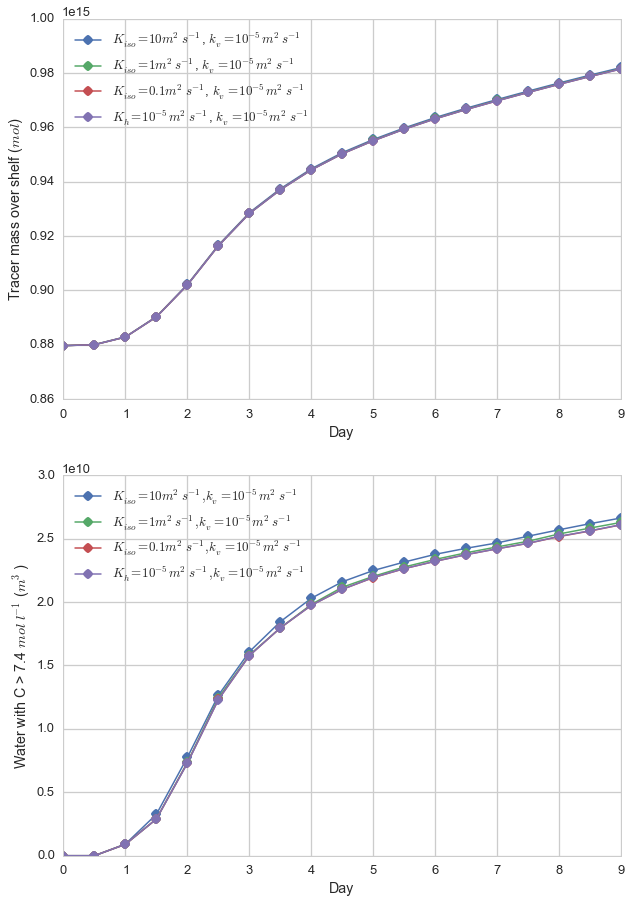

In [14]:
fig45=plt.figure(figsize=(10,15))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

ax1 = plt.subplot(2,1,1)

line1 = ax1.plot(times/2.0, TrMassCNT02Tr1,'o-',label='$K_{iso}=10m^2s^{-1}$, $k_v=10^{-5}m^2s^{-1}$')
line2 = ax1.plot(times/2.0, TrMassCNT03Tr1,'o-', label='$K_{iso}=1m^2s^{-1}$, $k_v=10^{-5}m^2s^{-1}$')
line3 = ax1.plot(times/2.0, TrMassCNT04Tr1,'o-', label='$K_{iso}=0.1m^2s^{-1}$, $k_v=10^{-5}m^2s^{-1}$')
line4 = ax1.plot(times/2.0, TrMassNOR02Tr1,'o-', label='$K_{h}=10^{-5}m^2s^{-1}$, $k_v=10^{-5}m^2s^{-1}$')

plt.ylabel('Tracer mass over shelf ($mol$) ')
plt.xlabel('Day')


ax2 = plt.subplot(2,1,2)

line1 = ax2.plot(times/2.0, WatCNT02Tr1,'o-',label='$K_{iso}=10m^2s^{-1}, k_v=10^{-5}m^2s^{-1}$')
line2 = ax2.plot(times/2.0, WatCNT03Tr1,'o-', label='$K_{iso}=1m^2s^{-1}, k_v=10^{-5}m^2s^{-1}$')
line3 = ax2.plot(times/2.0, WatCNT04Tr1,'o-', label='$K_{iso}=0.1m^2s^{-1}, k_v=10^{-5}m^2s^{-1}$')
line4 = ax2.plot(times/2.0, WatNOR02Tr1,'o-', label='$K_{h}=10^{-5}m^2s^{-1}, k_v=10^{-5}m^2s^{-1}$')

plt.ylabel('Water with C > 7.4 $mol$ $l^{-1}$ ($m^3$)')
plt.xlabel('Day')
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)


#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr1.eps', format='eps', dpi=1000, bbox_inches='tight')

        
        


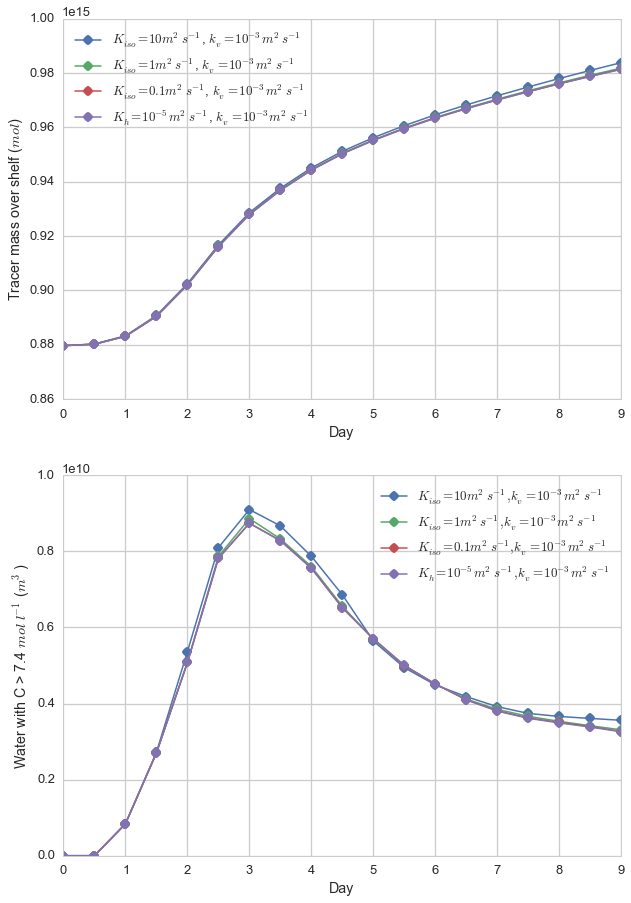

In [15]:


fig45=plt.figure(figsize=(10,15))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

ax1 = plt.subplot(2,1,1)

line1 = ax1.plot(times/2.0, TrMassCNT02Tr3,'o-',label='$K_{iso}=10m^2s^{-1}$, $k_v=10^{-3}m^2s^{-1}$')
line2 = ax1.plot(times/2.0, TrMassCNT03Tr3,'o-', label='$K_{iso}=1m^2s^{-1}$, $k_v=10^{-3}m^2s^{-1}$')
line3 = ax1.plot(times/2.0, TrMassCNT04Tr3,'o-', label='$K_{iso}=0.1m^2s^{-1}$, $k_v=10^{-3}m^2s^{-1}$')
line4 = ax1.plot(times/2.0, TrMassNOR02Tr3,'o-', label='$K_{h}=10^{-5}m^2s^{-1}$, $k_v=10^{-3}m^2s^{-1}$')

plt.ylabel('Tracer mass over shelf ($mol$) ')
plt.xlabel('Day')


ax2 = plt.subplot(2,1,2)

line1 = ax2.plot(times/2.0, WatCNT02Tr3,'o-',label='$K_{iso}=10m^2s^{-1}, k_v=10^{-3}m^2s^{-1}$')
line2 = ax2.plot(times/2.0, WatCNT03Tr3,'o-', label='$K_{iso}=1m^2s^{-1}, k_v=10^{-3}m^2s^{-1}$')
line3 = ax2.plot(times/2.0, WatCNT04Tr3,'o-', label='$K_{iso}=0.1m^2s^{-1}, k_v=10^{-3}m^2s^{-1}$')
line4 = ax2.plot(times/2.0, WatNOR02Tr3,'o-', label='$K_{h}=10^{-5}m^2s^{-1}, k_v=10^{-3}m^2s^{-1}$')

plt.ylabel('Water with C > 7.4 $mol$ $l^{-1}$ ($m^3$)')
plt.xlabel('Day')
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)


#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr3.eps', format='eps', dpi=1000, bbox_inches='tight')

        
        


### Effect of Changing 3D Diff

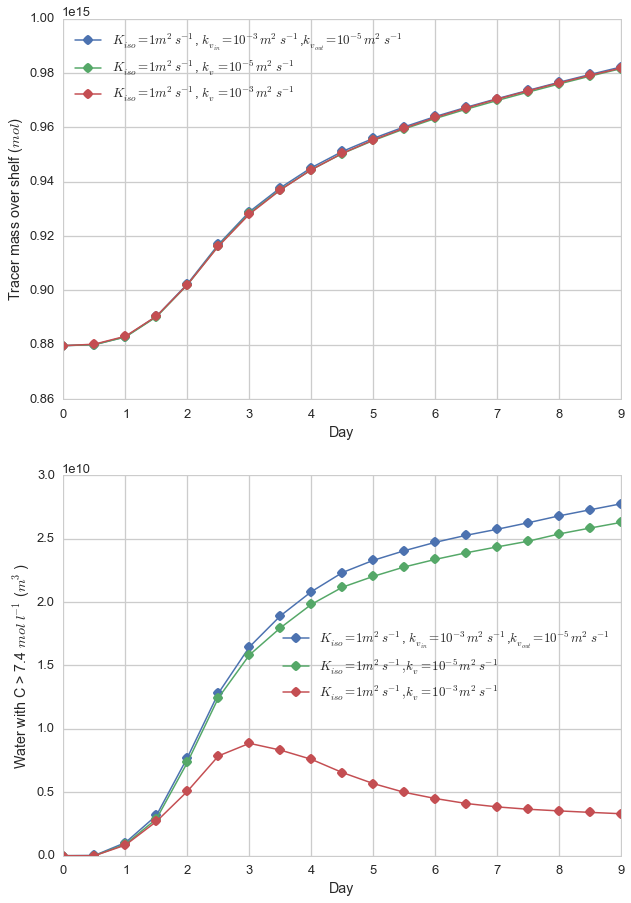

In [16]:
fig45=plt.figure(figsize=(10,15))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

ax1 = plt.subplot(2,1,1)

line1 = ax1.plot(times/2.0, TrMass3D06Tr1,'o-',label='$K_{iso}=1m^2s^{-1}$, $k_{v_{in}}=10^{-3}m^2s^{-1}$,$k_{v_{out}}=10^{-5}m^2s^{-1}$')
line2 = ax1.plot(times/2.0, TrMassCNT03Tr1,'o-', label='$K_{iso}=1m^2s^{-1}$, $k_v=10^{-5}m^2s^{-1}$')
line3 = ax1.plot(times/2.0, TrMassCNT03Tr3,'o-', label='$K_{iso}=1m^2s^{-1}$, $k_v=10^{-3}m^2s^{-1}$')

plt.ylabel('Tracer mass over shelf ($mol$) ')
plt.xlabel('Day')


ax2 = plt.subplot(2,1,2)

line1 = ax2.plot(times/2.0, Wat3D06Tr1,'o-',label='$K_{iso}=1m^2s^{-1}$, $k_{v_{in}}=10^{-3}m^2s^{-1}$,$k_{v_{out}}=10^{-5}m^2s^{-1}$')
line2 = ax2.plot(times/2.0, WatCNT03Tr1,'o-', label='$K_{iso}=1m^2s^{-1}, k_v=10^{-5}m^2s^{-1}$')
line3 = ax2.plot(times/2.0, WatCNT03Tr3,'o-', label='$K_{iso}=1m^2s^{-1}, k_v=10^{-3}m^2s^{-1}$')

plt.ylabel('Water with C > 7.4 $mol$ $l^{-1}$ ($m^3$)')
plt.xlabel('Day')
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)


#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelf3DDiffEffect1.eps', format='eps', dpi=1000, bbox_inches='tight')

        
        


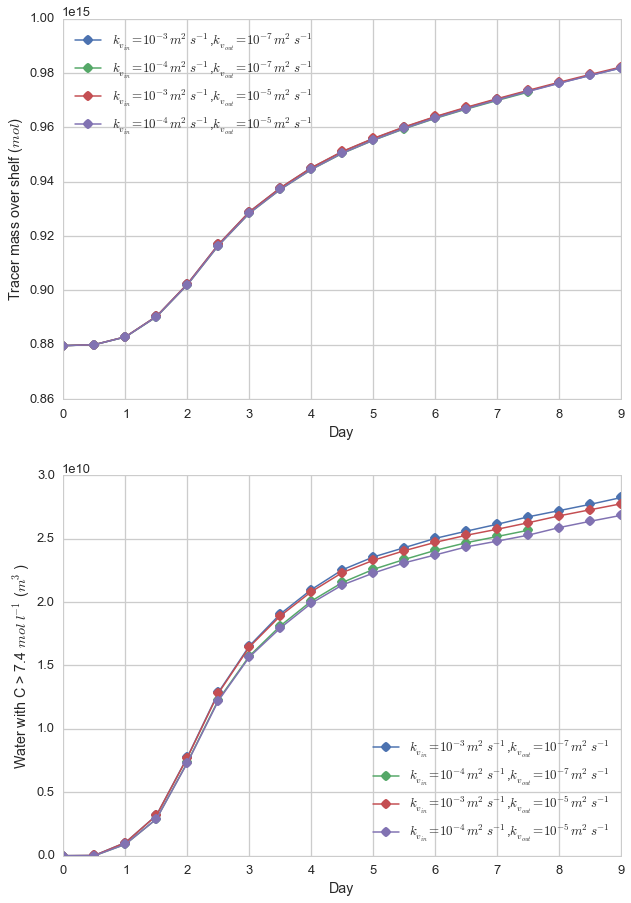

In [17]:
fig45=plt.figure(figsize=(10,15))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)
times2 = np.arange(0,16,1)

ax1 = plt.subplot(2,1,1)

line1 = ax1.plot(times/2.0, TrMass3D04Tr1,'o-',label='$k_{v_{in}}=10^{-3}m^2s^{-1}$,$k_{v_{out}}=10^{-7}m^2s^{-1}$')
line2 = ax1.plot(times2/2.0, TrMass3D05Tr1,'o-', label='$k_{v_{in}}=10^{-4}m^2s^{-1}$,$k_{v_{out}}=10^{-7}m^2s^{-1}$')
line3 = ax1.plot(times/2.0, TrMass3D06Tr1,'o-', label='$k_{v_{in}}=10^{-3}m^2s^{-1}$,$k_{v_{out}}=10^{-5}m^2s^{-1}$')
line4 = ax1.plot(times/2.0, TrMass3D07Tr1,'o-', label='$k_{v_{in}}=10^{-4}m^2s^{-1}$,$k_{v_{out}}=10^{-5}m^2s^{-1}$')

plt.ylabel('Tracer mass over shelf ($mol$) ')
plt.xlabel('Day')


ax2 = plt.subplot(2,1,2)

line1 = ax2.plot(times/2.0, Wat3D04Tr1,'o-',label='$k_{v_{in}}=10^{-3}m^2s^{-1}$,$k_{v_{out}}=10^{-7}m^2s^{-1}$')
line2 = ax2.plot(times2/2.0, Wat3D05Tr1,'o-', label='$k_{v_{in}}=10^{-4}m^2s^{-1}$,$k_{v_{out}}=10^{-7}m^2s^{-1}$')
line3 = ax2.plot(times/2.0, Wat3D06Tr1,'o-', label='$k_{v_{in}}=10^{-3}m^2s^{-1}$,$k_{v_{out}}=10^{-5}m^2s^{-1}$')
line4 = ax2.plot(times/2.0, Wat3D07Tr1,'o-', label='$k_{v_{in}}=10^{-4}m^2s^{-1}$,$k_{v_{out}}=10^{-5}m^2s^{-1}$')

plt.ylabel('Water with C > 7.4 $mol$ $l^{-1}$ ($m^3$)')
plt.xlabel('Day')
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)


#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelf3DDiffEffect2.eps', format='eps', dpi=1000, bbox_inches='tight')



### Effect of horizontal diffusivity in NOREDI

NameError: name 'TrMassNOR03Tr1' is not defined

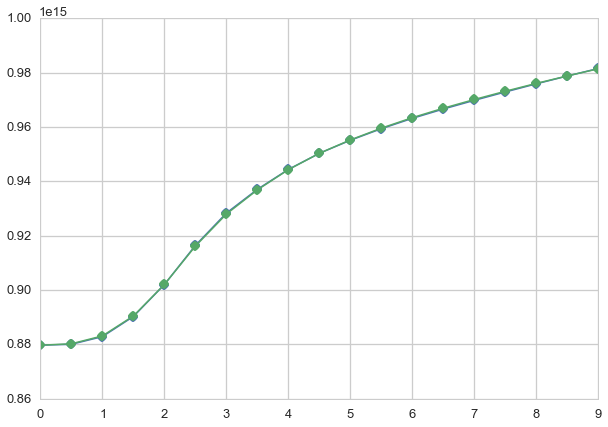

In [18]:
fig45=plt.figure(figsize=(10,15))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

ax1 = plt.subplot(2,1,1)

line1 = ax1.plot(times/2.0, TrMassNOR02Tr1,'o-',label='$k_h=10^{-5}m^2s^{-1}$,$k_v=10^{-5}m^2s^{-1}$')
line2 = ax1.plot(times/2.0, TrMassNOR02Tr3,'o-', label='$k_h=10^{-5}m^2s^{-1}$,$k_v=10^{-3}m^2s^{-1}$')
line3 = ax1.plot(times/2.0, TrMassNOR03Tr1,'o-', label='$k_h=10^{-7}m^2s^{-1}$,$k_v=10^{-5}m^2s^{-1}$')
line3 = ax1.plot(times/2.0, TrMassNOR03Tr3,'o-', label='$k_h=10^{-7}m^2s^{-1}$,$k_v=10^{-3}m^2s^{-1}$')

plt.ylabel('Tracer mass over shelf ($mol$) ')
plt.xlabel('Day')


ax2 = plt.subplot(2,1,2)

line1 = ax2.plot(times/2.0, WatNOR02Tr1,'o-',label='$k_h=10^{-5}m^2s^{-1}$,$k_v=10^{-5}m^2s^{-1}$')
line2 = ax2.plot(times/2.0, WatNOR02Tr3,'o-', label='$k_h=10^{-5}m^2s^{-1}$,$k_v=10^{-3}m^2s^{-1}$')
line3 = ax2.plot(times/2.0, WatNOR03Tr1,'o-', label='$k_h=10^{-7}m^2s^{-1}$,$k_v=10^{-5}m^2s^{-1}$')
line3 = ax2.plot(times/2.0, WatNOR03Tr3,'o-', label='$k_h=10^{-7}m^2s^{-1}$,$k_v=10^{-3}m^2s^{-1}$')

plt.ylabel('Water with C > 7.4 $mol$ $l^{-1}$ ($m^3$)')
plt.xlabel('Day')
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)


#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfNOREDIHorDiffEffect.eps', format='eps', dpi=1000, bbox_inches='tight')



### Canyon Effects
#### A) Numerical 

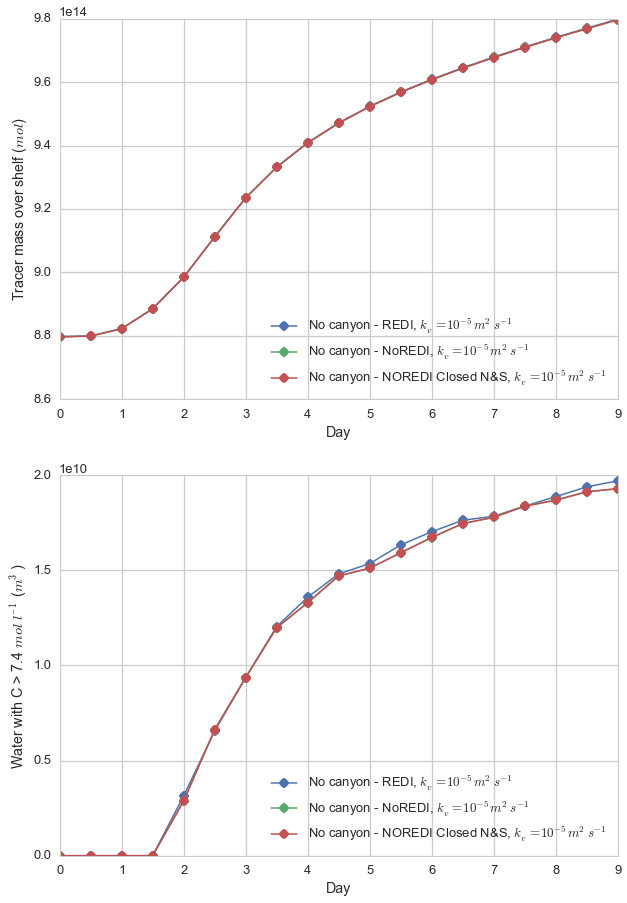

In [19]:
fig45=plt.figure(figsize=(10,15))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

ax1 = plt.subplot(2,1,1)

line1 = ax1.plot(times/2.0, TrMassCNT07Tr1,'o-',label='No canyon - REDI, $k_v=10^{-5}m^2s^{-1}$')
line2 = ax1.plot(times/2.0, TrMassNOR04Tr1,'o-', label='No canyon - NoREDI, $k_v=10^{-5}m^2s^{-1}$')
line3 = ax1.plot(times/2.0, TrMassNOR06Tr1,'o-', label='No canyon - NOREDI Closed N&S, $k_v=10^{-5}m^2s^{-1}$')

plt.ylabel('Tracer mass over shelf ($mol$) ')
plt.xlabel('Day')


ax2 = plt.subplot(2,1,2)

line1 = ax2.plot(times/2.0, WatCNT07Tr1,'o-',label='No canyon - REDI, $k_v=10^{-5}m^2s^{-1}$')
line2 = ax2.plot(times/2.0, WatNOR04Tr1,'o-', label='No canyon - NoREDI, $k_v=10^{-5}m^2s^{-1}$')
line3 = ax2.plot(times/2.0, WatNOR06Tr1,'o-', label='No canyon - NOREDI Closed N&S, $k_v=10^{-5}m^2s^{-1}$')

plt.ylabel('Water with C > 7.4 $mol$ $l^{-1}$ ($m^3$)')
plt.xlabel('Day')
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)


#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfNoCanyonCasesTr1.eps', format='eps', dpi=1000, bbox_inches='tight')



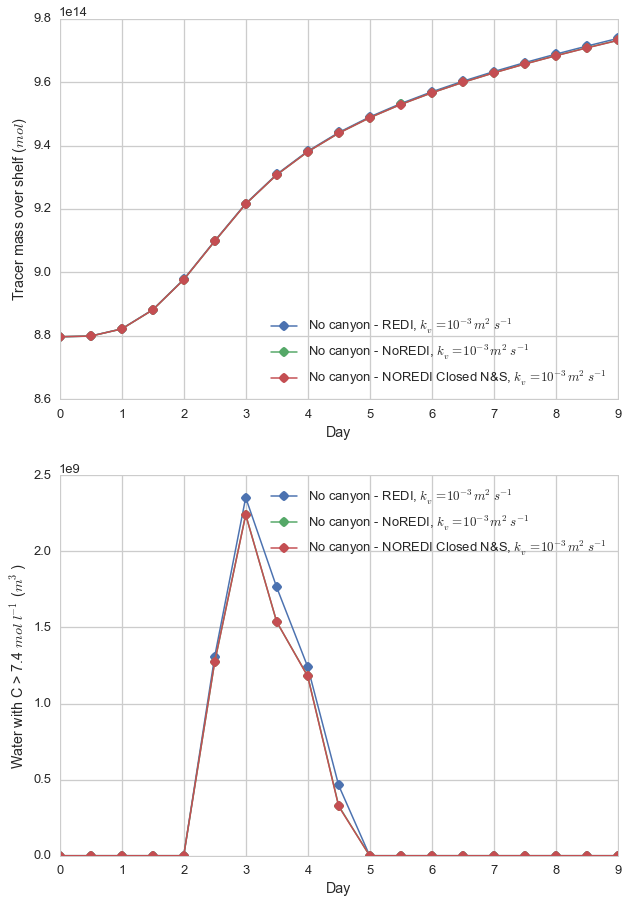

In [20]:
fig45=plt.figure(figsize=(10,15))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

ax1 = plt.subplot(2,1,1)

line1 = ax1.plot(times/2.0, TrMassCNT07Tr3,'o-',label='No canyon - REDI, $k_v=10^{-3}m^2s^{-1}$')
line2 = ax1.plot(times/2.0, TrMassNOR04Tr3,'o-', label='No canyon - NoREDI, $k_v=10^{-3}m^2s^{-1}$')
line3 = ax1.plot(times/2.0, TrMassNOR06Tr3,'o-', label='No canyon - NOREDI Closed N&S, $k_v=10^{-3}m^2s^{-1}$')

plt.ylabel('Tracer mass over shelf ($mol$) ')
plt.xlabel('Day')


ax2 = plt.subplot(2,1,2)

line1 = ax2.plot(times/2.0, WatCNT07Tr3,'o-',label='No canyon - REDI, $k_v=10^{-3}m^2s^{-1}$')
line2 = ax2.plot(times/2.0, WatNOR04Tr3,'o-', label='No canyon - NoREDI, $k_v=10^{-3}m^2s^{-1}$')
line3 = ax2.plot(times/2.0, WatNOR06Tr3,'o-', label='No canyon - NOREDI Closed N&S, $k_v=10^{-3}m^2s^{-1}$')

plt.ylabel('Water with C > 7.4 $mol$ $l^{-1}$ ($m^3$)')
plt.xlabel('Day')
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)


#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfNoCanyonCasesTr3.eps', format='eps', dpi=1000, bbox_inches='tight')



#### B) Effects of enhanced vertical diffusivity within the canyon

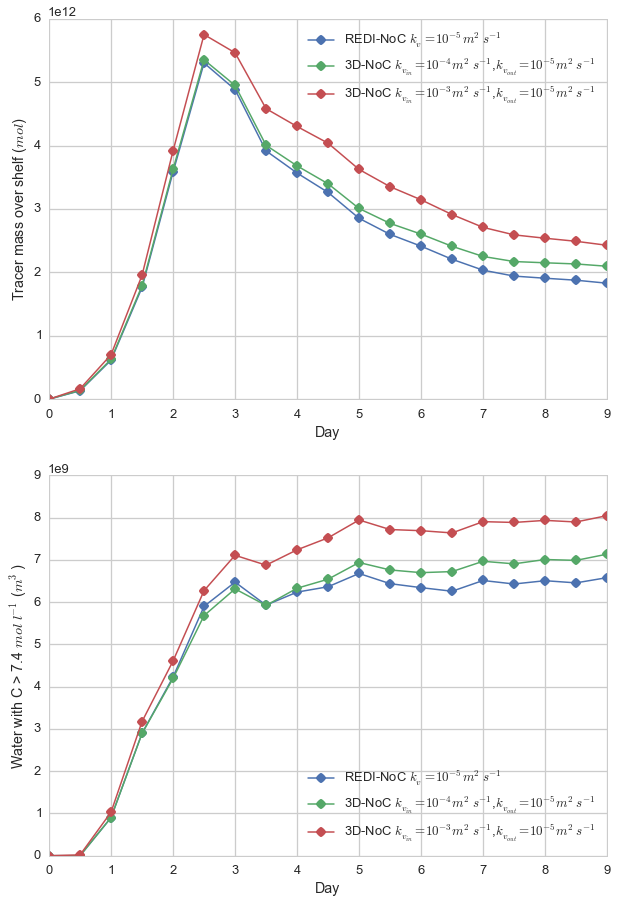

In [22]:
fig45=plt.figure(figsize=(10,15))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

ax1 = plt.subplot(2,1,1)

line1 = ax1.plot(times/2.0, TrMassCNT03Tr1-TrMassCNT07Tr1,'o-',label='REDI-NoC $k_v=10^{-5}m^2s^{-1}$ ')
line3 = ax1.plot(times/2.0, TrMass3D07Tr1-TrMassCNT07Tr1,'o-', label='3D-NoC $k_{v_{in}}=10^{-4}m^2s^{-1}$,$k_{v_{out}}=10^{-5}m^2s^{-1}$')
line3 = ax1.plot(times/2.0, TrMass3D06Tr1-TrMassCNT07Tr1,'o-', label='3D-NoC $k_{v_{in}}=10^{-3}m^2s^{-1}$,$k_{v_{out}}=10^{-5}m^2s^{-1}$')

plt.ylabel('Tracer mass over shelf ($mol$) ')
plt.xlabel('Day')


ax2 = plt.subplot(2,1,2)

line1 = ax2.plot(times/2.0, WatCNT03Tr1-WatCNT07Tr1,'o-',label='REDI-NoC $k_v=10^{-5}m^2s^{-1}$')
line3 = ax2.plot(times/2.0, Wat3D07Tr1-WatCNT07Tr1,'o-', label='3D-NoC $k_{v_{in}}=10^{-4}m^2s^{-1}$,$k_{v_{out}}=10^{-5}m^2s^{-1}$')
line3 = ax2.plot(times/2.0, Wat3D06Tr1-WatCNT07Tr1,'o-', label='3D-NoC $k_{v_{in}}=10^{-3}m^2s^{-1}$,$k_{v_{out}}=10^{-5}m^2s^{-1}$')

plt.ylabel('Water with C > 7.4 $mol$ $l^{-1}$ ($m^3$)')
plt.xlabel('Day')
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)


#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfNoCanyonEnhancedDiff.eps', format='eps', dpi=1000, bbox_inches='tight')


#### C) Boundary effects

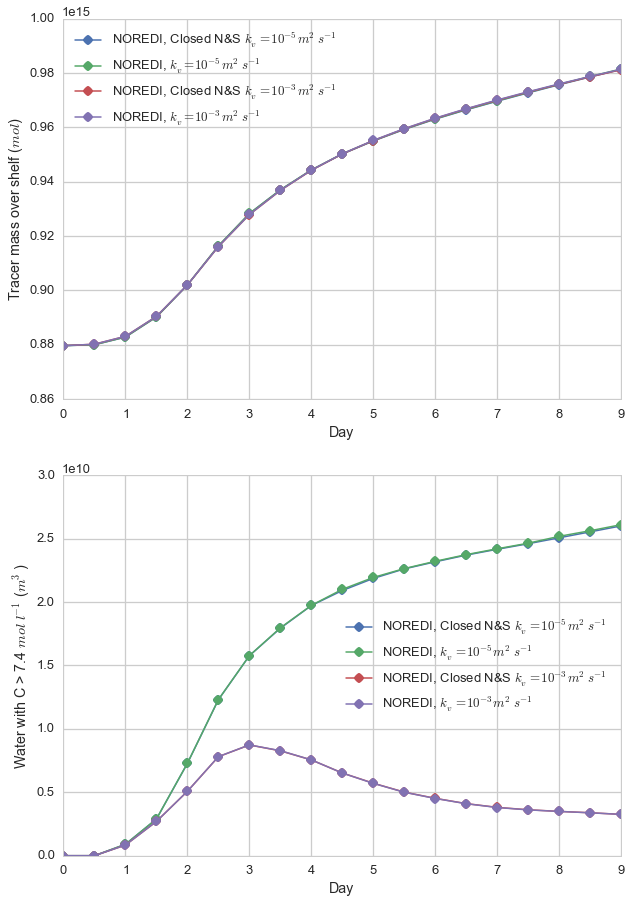

In [26]:
fig45=plt.figure(figsize=(10,15))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

ax1 = plt.subplot(2,1,1)

line1 = ax1.plot(times/2.0, TrMassNOR05Tr1,'o-',label='NOREDI, Closed N&S $k_v=10^{-5}m^2s^{-1}$ ')
line3 = ax1.plot(times/2.0, TrMassNOR02Tr1,'o-', label='NOREDI, $k_{v}=10^{-5}m^2s^{-1}$')
line1 = ax1.plot(times/2.0, TrMassNOR05Tr3,'o-',label='NOREDI, Closed N&S $k_v=10^{-3}m^2s^{-1}$ ')
line3 = ax1.plot(times/2.0, TrMassNOR02Tr3,'o-', label='NOREDI, $k_{v}=10^{-3}m^2s^{-1}$')

plt.ylabel('Tracer mass over shelf ($mol$) ')
plt.xlabel('Day')


ax2 = plt.subplot(2,1,2)

line1 = ax2.plot(times/2.0, WatNOR05Tr1,'o-',label='NOREDI, Closed N&S $k_v=10^{-5}m^2s^{-1}$ ')
line3 = ax2.plot(times/2.0, WatNOR02Tr1,'o-', label='NOREDI, $k_v=10^{-5}m^2s^{-1}$ ')
line1 = ax2.plot(times/2.0, WatNOR05Tr3,'o-',label='NOREDI, Closed N&S $k_v=10^{-3}m^2s^{-1}$ ')
line3 = ax2.plot(times/2.0, WatNOR02Tr3,'o-', label='NOREDI, $k_v=10^{-3}m^2s^{-1}$ ')

plt.ylabel('Water with C > 7.4 $mol$ $l^{-1}$ ($m^3$)')
plt.xlabel('Day')
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)



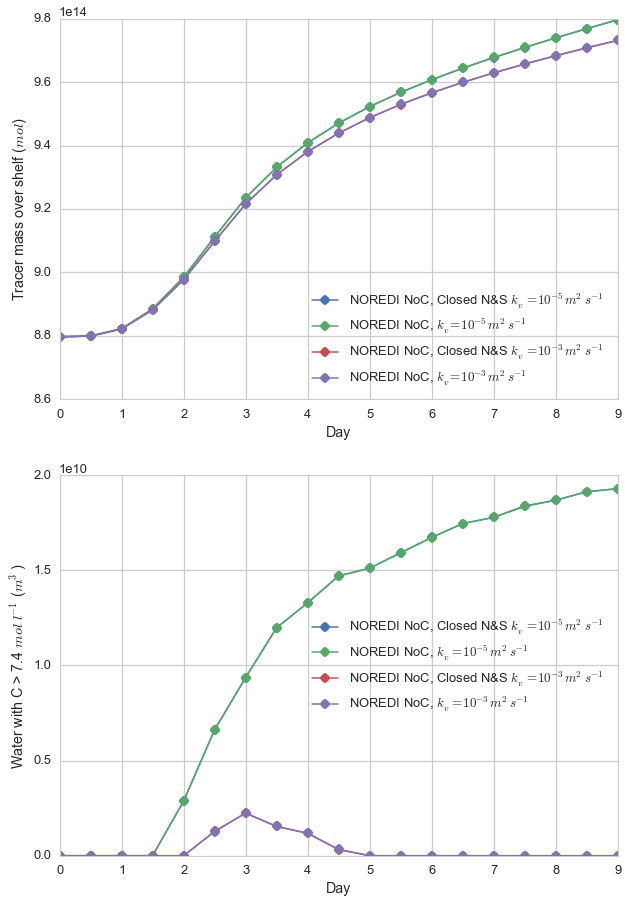

In [27]:
fig45=plt.figure(figsize=(10,15))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

ax1 = plt.subplot(2,1,1)

line1 = ax1.plot(times/2.0, TrMassNOR06Tr1,'o-',label='NOREDI NoC, Closed N&S $k_v=10^{-5}m^2s^{-1}$ ')
line3 = ax1.plot(times/2.0, TrMassNOR04Tr1,'o-', label='NOREDI NoC, $k_{v}=10^{-5}m^2s^{-1}$')
line1 = ax1.plot(times/2.0, TrMassNOR06Tr3,'o-',label='NOREDI NoC, Closed N&S $k_v=10^{-3}m^2s^{-1}$ ')
line3 = ax1.plot(times/2.0, TrMassNOR04Tr3,'o-', label='NOREDI NoC, $k_{v}=10^{-3}m^2s^{-1}$')

plt.ylabel('Tracer mass over shelf ($mol$) ')
plt.xlabel('Day')


ax2 = plt.subplot(2,1,2)

line1 = ax2.plot(times/2.0, WatNOR06Tr1,'o-',label='NOREDI NoC, Closed N&S $k_v=10^{-5}m^2s^{-1}$ ')
line3 = ax2.plot(times/2.0, WatNOR04Tr1,'o-', label='NOREDI NoC, $k_v=10^{-5}m^2s^{-1}$ ')
line1 = ax2.plot(times/2.0, WatNOR06Tr3,'o-',label='NOREDI NoC, Closed N&S $k_v=10^{-3}m^2s^{-1}$ ')
line3 = ax2.plot(times/2.0, WatNOR04Tr3,'o-', label='NOREDI NoC, $k_v=10^{-3}m^2s^{-1}$ ')

plt.ylabel('Water with C > 7.4 $mol$ $l^{-1}$ ($m^3$)')
plt.xlabel('Day')
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)


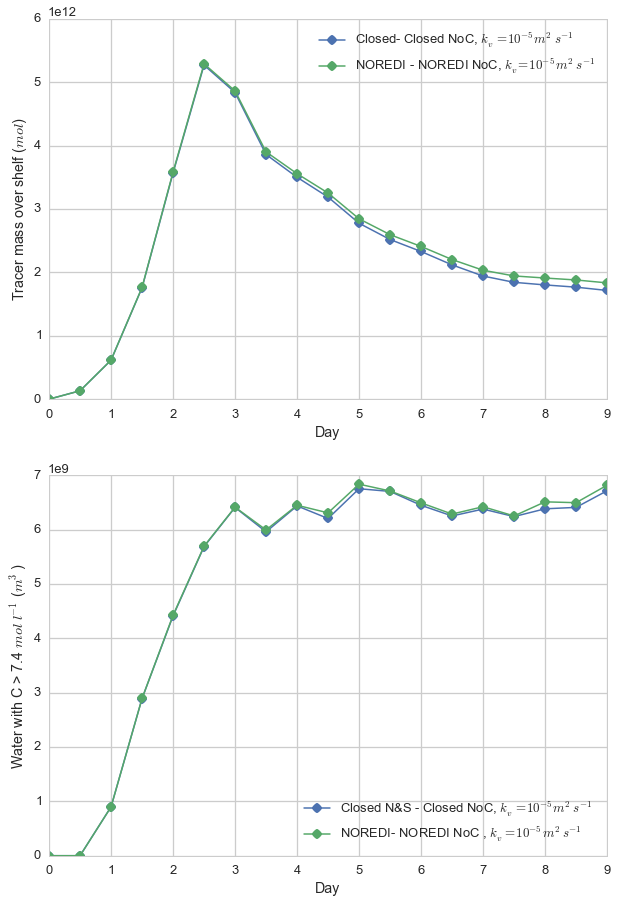

In [28]:
fig45=plt.figure(figsize=(10,15))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

ax1 = plt.subplot(2,1,1)

line1 = ax1.plot(times/2.0, TrMassNOR05Tr1-TrMassNOR06Tr1,'o-',label='Closed- Closed NoC, $k_v=10^{-5}m^2s^{-1}$ ')
line3 = ax1.plot(times/2.0, TrMassNOR02Tr1-TrMassNOR04Tr1,'o-', label='NOREDI - NOREDI NoC, $k_{v}=10^{-5}m^2s^{-1}$')

plt.ylabel('Tracer mass over shelf ($mol$) ')
plt.xlabel('Day')


ax2 = plt.subplot(2,1,2)

line1 = ax2.plot(times/2.0, WatNOR05Tr1-WatNOR06Tr1,'o-',label='Closed N&S - Closed NoC, $k_v=10^{-5}m^2s^{-1}$ ')
line3 = ax2.plot(times/2.0, WatNOR02Tr1-WatNOR04Tr1,'o-', label='NOREDI- NOREDI NoC , $k_v=10^{-5}m^2s^{-1}$ ')

plt.ylabel('Water with C > 7.4 $mol$ $l^{-1}$ ($m^3$)')
plt.xlabel('Day')
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)


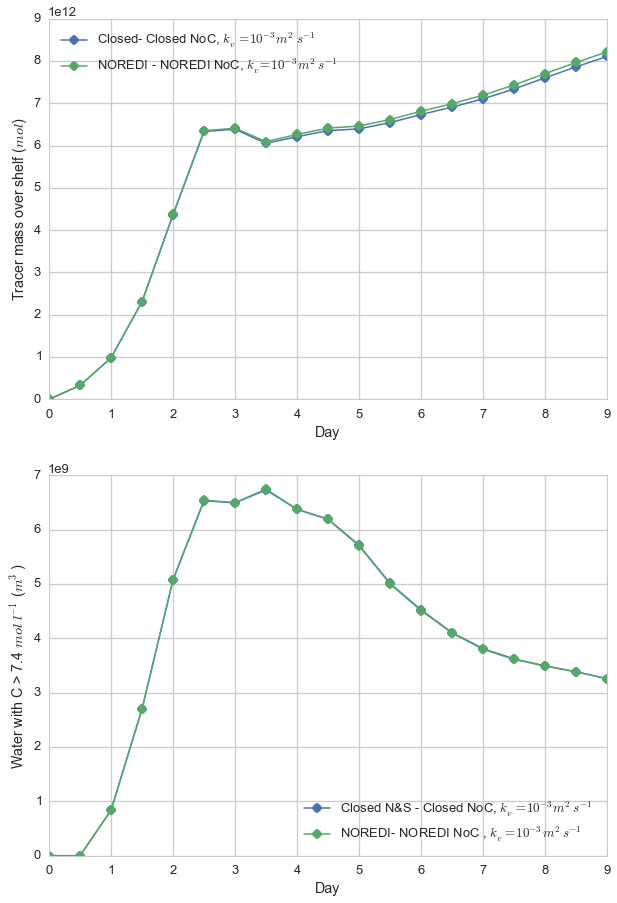

In [29]:
fig45=plt.figure(figsize=(10,15))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

ax1 = plt.subplot(2,1,1)

line1 = ax1.plot(times/2.0, TrMassNOR05Tr3-TrMassNOR06Tr3,'o-',label='Closed- Closed NoC, $k_v=10^{-3}m^2s^{-1}$ ')
line3 = ax1.plot(times/2.0, TrMassNOR02Tr3-TrMassNOR04Tr3,'o-', label='NOREDI - NOREDI NoC, $k_{v}=10^{-3}m^2s^{-1}$')

plt.ylabel('Tracer mass over shelf ($mol$) ')
plt.xlabel('Day')


ax2 = plt.subplot(2,1,2)

line1 = ax2.plot(times/2.0, WatNOR05Tr3-WatNOR06Tr3,'o-',label='Closed N&S - Closed NoC, $k_v=10^{-3}m^2s^{-1}$ ')
line3 = ax2.plot(times/2.0, WatNOR02Tr3-WatNOR04Tr3,'o-', label='NOREDI- NOREDI NoC , $k_v=10^{-3}m^2s^{-1}$ ')

plt.ylabel('Water with C > 7.4 $mol$ $l^{-1}$ ($m^3$)')
plt.xlabel('Day')
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)
